In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 16), dpi=80);
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore")

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error, r2_score

<Figure size 640x1280 with 0 Axes>

In [2]:
##Loading gthe datset and cleaning dups
df=pd.read_csv('AEP_hourly.csv')
#print(df.dtypes,df.shape)
df=df.groupby('Datetime').AEP_MW.mean()
df=df.reset_index()

#creating the time series
df['Datetime']=pd.to_datetime(df['Datetime'])
new_df=df.set_index(['Datetime'])

new_df.sort_index(inplace=True)
##Creating full calendar
start=new_df.index[0]
end=new_df.index[-1]
full_calendar=pd.date_range(start, end,freq='H')
##Putting it all together
calendar=pd.DataFrame(full_calendar,columns=['Datetime']).set_index('Datetime')#,new_df.head()
final_df=calendar.join(new_df)
print(final_df.isnull().sum())
final_df=final_df.interpolate()
final_df.head()
print(final_df.isnull().sum())

monthly_df=final_df[['AEP_MW']].resample('M').sum()[3:-1]
monthly_df.columns=['energy']
monthly_df.to_csv('monthly_energy_consumption.csv')

AEP_MW    27
dtype: int64
AEP_MW    0
dtype: int64


In [3]:
monthly_df=pd.read_csv('monthly_energy_consumption.csv',
                      index_col=[0],parse_dates=True)
monthly_df.head()

,energy
Datetime,
2005-01-31,12735114.0
2005-02-28,11085745.0
2005-03-31,11847502.0
2005-04-30,10102660.5
2005-05-31,10181694.0


## Creating dataframe where to store results

In [4]:
results=pd.DataFrame(columns=['rmse_per_million'])
results

,rmse_per_million


# Splitting train and test

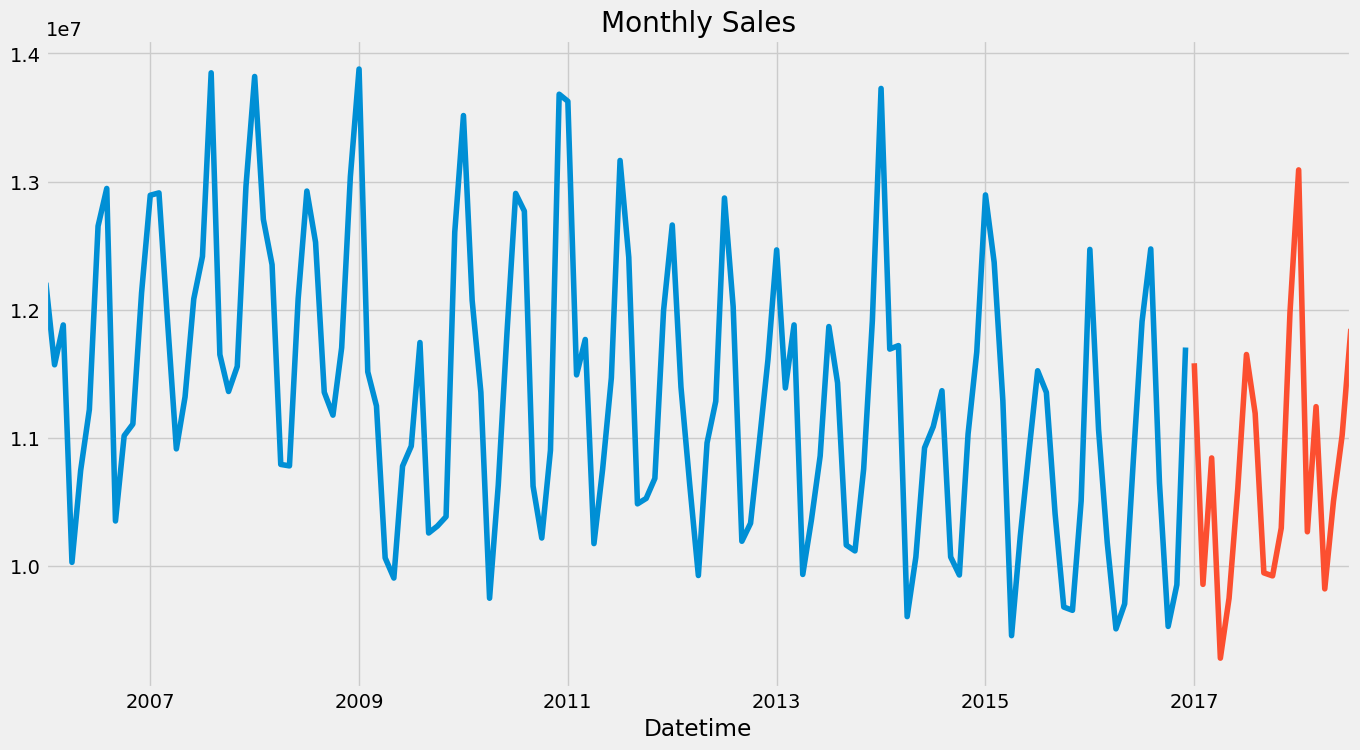

In [5]:
#let's take a look to our data before we start making predictions
train=monthly_df.loc['2006':'2016'].copy()
test=monthly_df.loc['2017':'2018'].copy()
train.energy.plot(figsize=(15,8), title= 'Monthly Sales', fontsize=14)
test.energy.plot(figsize=(15,8), title= 'Monthly Sales', fontsize=14);

# Basic Time Series Models: <a id='start'></a>

* These methods do not provide any depth. They just take one value as a reference and project it all the way into the future.

    1. [**Naive Method**](#naive). Let's assume that whatever the last value in time happened it will reproduce in the future.<br>
    2. [**Simple Average**](#simple_average).Let's pretend that the future will offer for every single moment the mean value of our past history.<br>
    3. [**Moving Average**](#moving_average). Let's pretend that the future will offer the rolling average value of our past history.<br>
    4. [**Simple Exponential Smoothing**](#simple_exponential). It is the same than a regular moving average but assigning higher weightsto the most recent values.<br>
    5. [**Holt's Linear Trend**](#holts_linear). It is just extending the regular Simple Exponential SMoothing but incorporating a new variable: a linear trend.
    6. [**Holt Winter's**](#holt_winters). Let's go one step further and add seasonaility.<br>

<a id='naive'></a>
## 1. Naive Method.
[back top](#start)

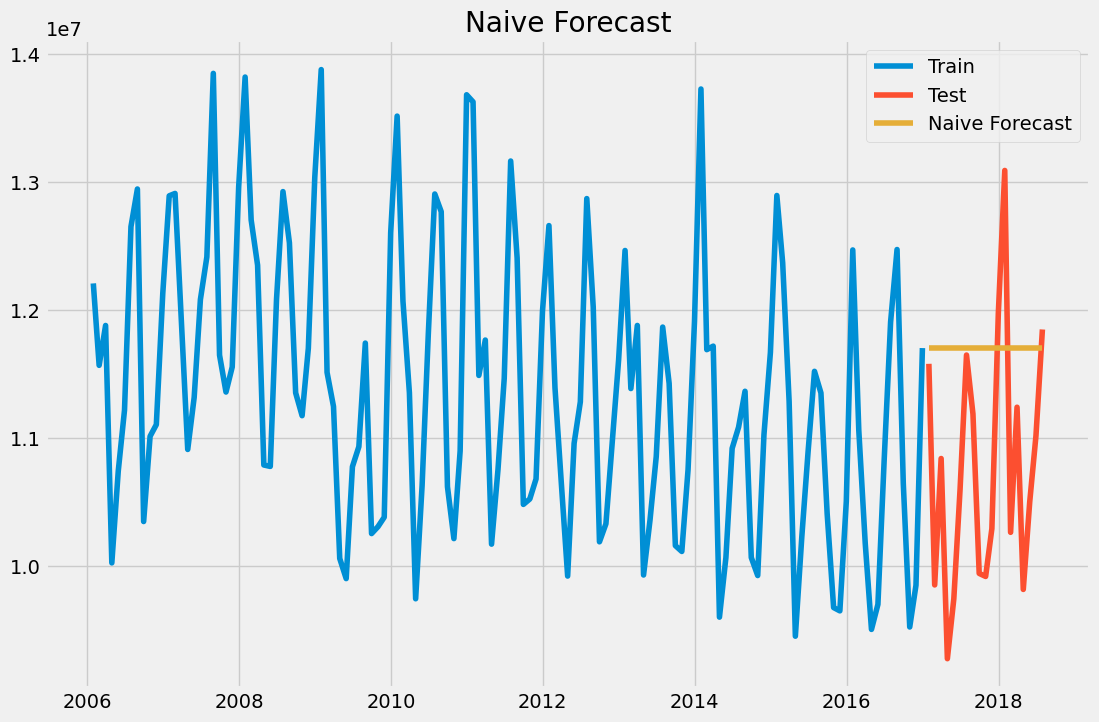

In [6]:
preds=test.copy()
preds['naive']=train[-1:].values[0][0]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast");

In [7]:
rms_naive = round(np.sqrt(mean_squared_error(test.energy, preds.naive)),2)
results.loc['naive']=rms_naive/1_000_000
results

,rmse_per_million
naive,1.325609


<a id='simple_average'></a>
## 2. Simple Average.
[back top](#start)

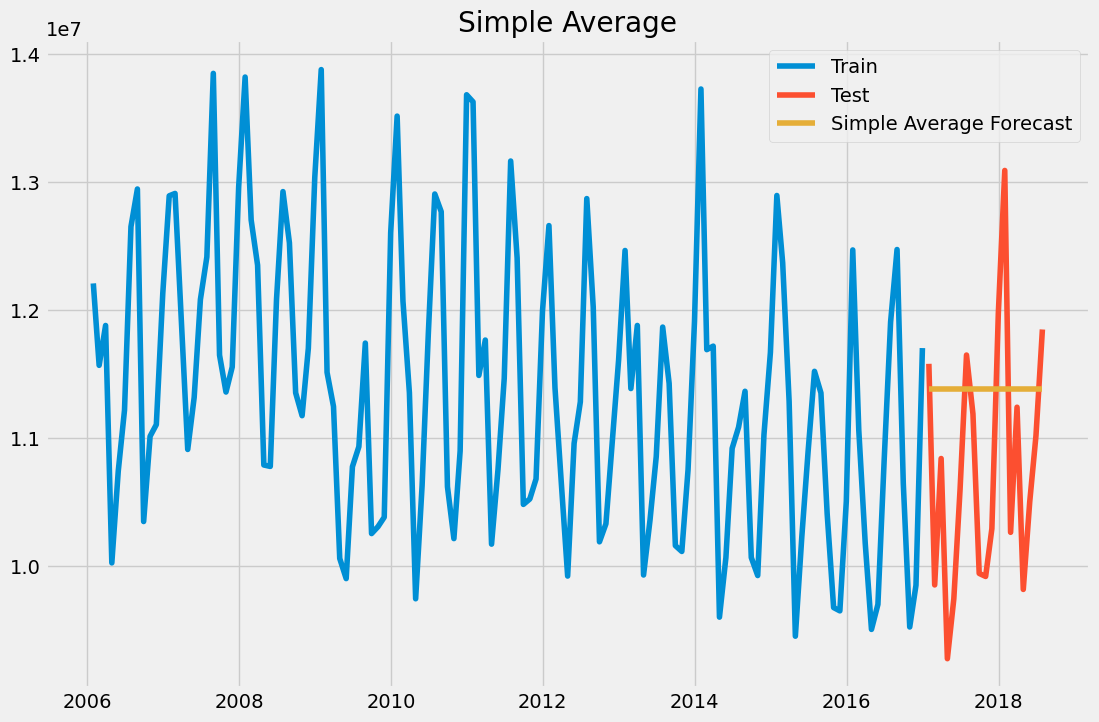

In [8]:
preds['average']=train.energy.mean()
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['average'], label='Simple Average Forecast')
plt.legend(loc='best')
plt.title("Simple Average");

In [9]:
rms_average = round(np.sqrt(mean_squared_error(test.energy, preds.average)),2)
results.loc['simple_average']=rms_average/1_000_000
results=results.sort_values('rmse_per_million')
results

,rmse_per_million
simple_average,1.122177
naive,1.325609


<a id='moving_average'></a>
## 3. Moving Average.
[back top](#start)

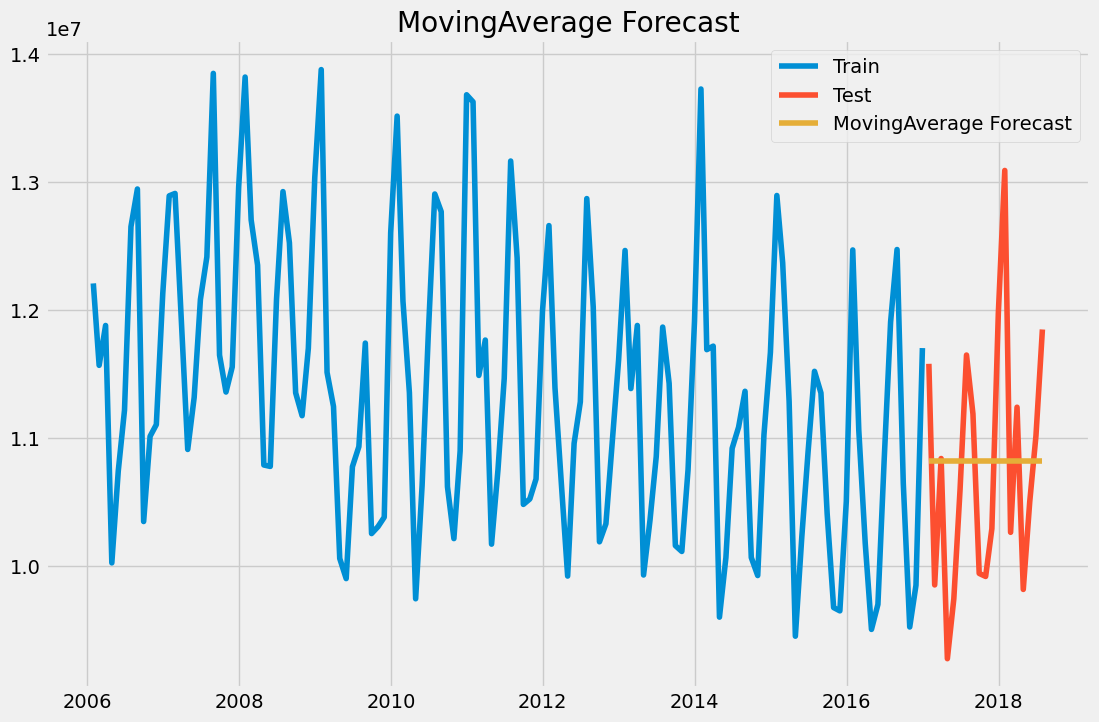

In [10]:
preds['moving_average']=train.energy.rolling(12).mean().iloc[-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['moving_average'], label='MovingAverage Forecast')
plt.legend(loc='best')
plt.title("MovingAverage Forecast");

In [11]:
rms_ma = round(np.sqrt(mean_squared_error(test.energy, preds.moving_average)),2)
results.loc['moving_average']=rms_ma/1_000_000
results=results.sort_values('rmse_per_million')
results

,rmse_per_million
moving_average,0.944048
simple_average,1.122177
naive,1.325609


<a id='simple_exponential'></a>
## 4. Simple Exponential Smoothing.
[back top](#start)

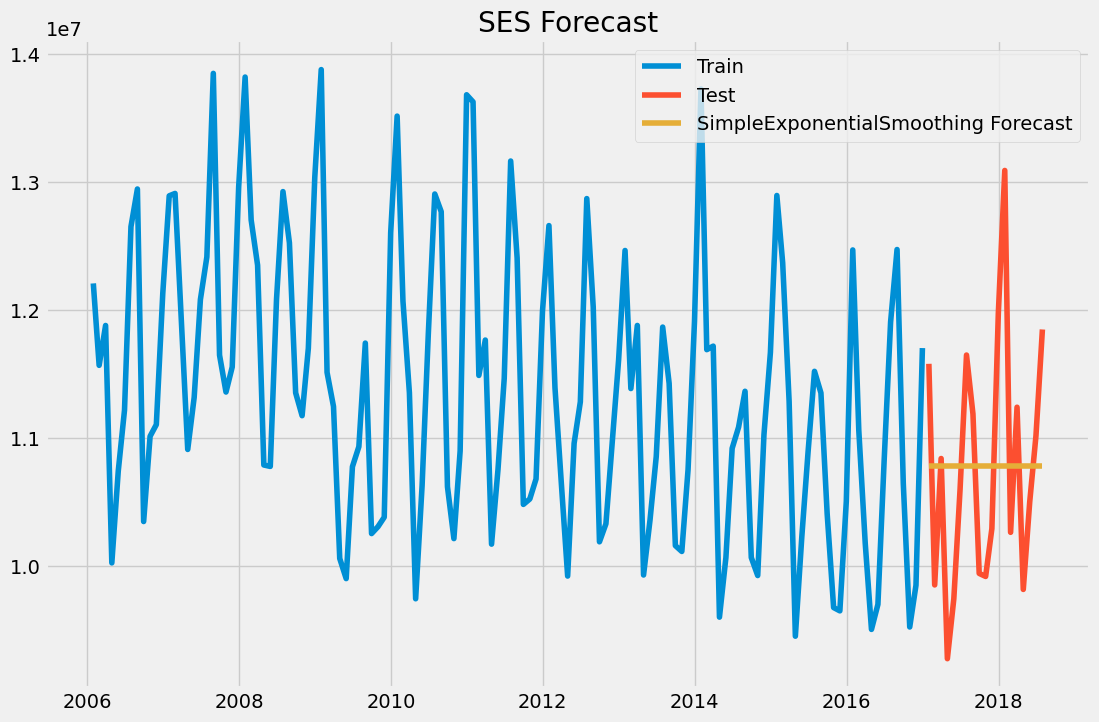

In [12]:
def ses(train,test,smoothing_level):
    fit = SimpleExpSmoothing(train).fit(smoothing_level=smoothing_level,optimized=False)
    preds= fit.forecast(len(test)).values
    rms_ses = round(np.sqrt(mean_squared_error(test, preds)),2)
    return rms_ses
selected_sl=1000
rmse=1_000_000_000
for sl in np.linspace(0.1,1,5):
    solution=ses(train.energy.to_period('M'), test.energy,sl)
    #print(sl,solution)
    if solution<rmse:
        rmse=solution
        selected_sl=sl
#added to_period to avoid a warning. Just aesthetics
fit2 = SimpleExpSmoothing(train.energy.to_period('M')).fit(smoothing_level=selected_sl,optimized=False)
preds['SimpleExponentialSmoothing'] = fit2.forecast(len(test)).values
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['SimpleExponentialSmoothing'], label='SimpleExponentialSmoothing Forecast')
plt.legend(loc='best')
plt.title("SES Forecast");

In [13]:
rms_ses = round(np.sqrt(mean_squared_error(test.energy, preds.SimpleExponentialSmoothing)),2)
results.loc['SES']=rms_ses/1_000_000
results=results.sort_values('rmse_per_million')
results

,rmse_per_million
SES,0.942778
moving_average,0.944048
simple_average,1.122177
naive,1.325609


<a id='holts_linear'></a>
## 5. Holt's Linear Trend.
[back top](#start)

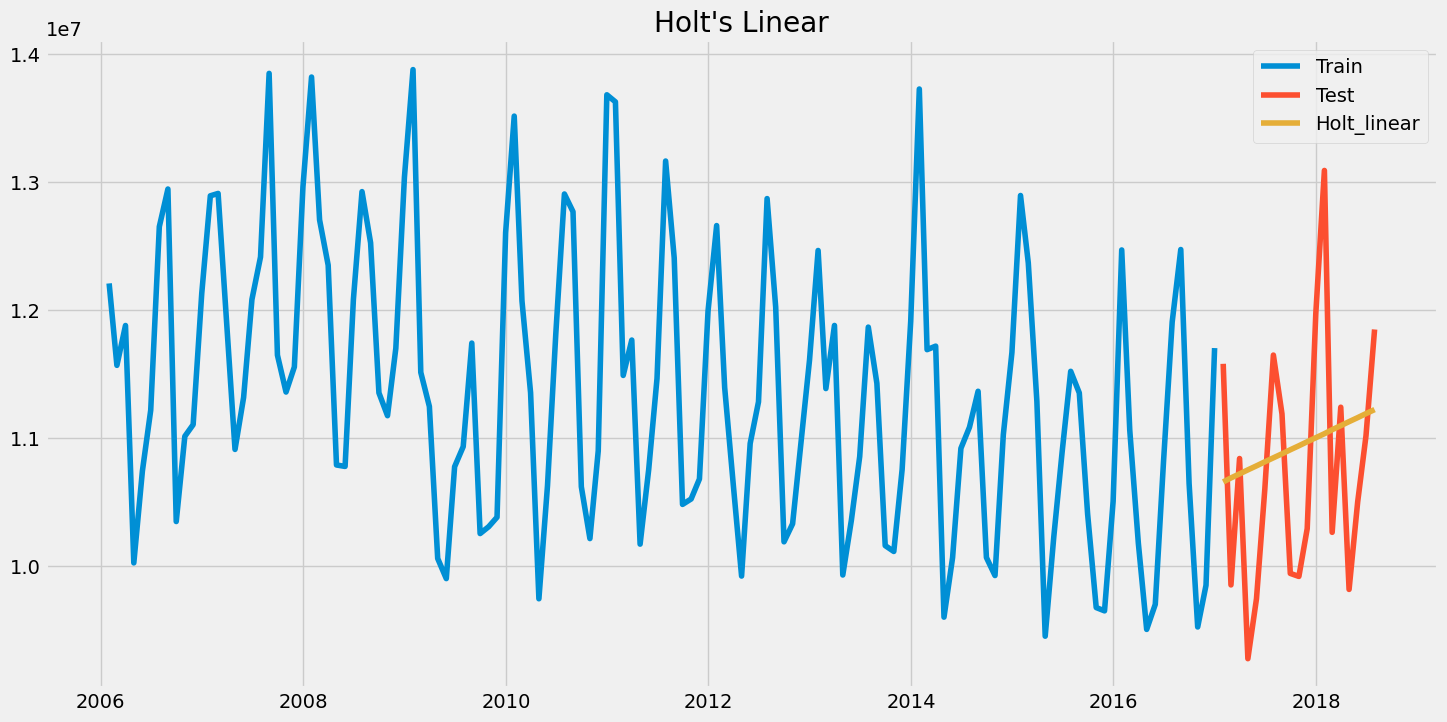

In [14]:
def holt(train,test,smoothing_level, smoothing_slope):
    fit = Holt(train).fit(smoothing_level=smoothing_level,smoothing_slope = smoothing_slope,optimized=False,use_brute=True)
    preds= fit.forecast(len(test)).values
    rms_ses = round(np.sqrt(mean_squared_error(test, preds)),2)
    return rms_ses
selected_sl=1000
selected_ss=1000

rmse=1_000_000_000
for sl in np.linspace(0.1,1,5):
    for ss in np.linspace(0.1,1,5):
        solution=holt(train.energy.to_period('M'), test.energy,sl, ss)
    #print(sl,solution)
        if solution<rmse:
            rmse=solution
            selected_sl=sl
            selected_ss=ss
            
#The first model providing more than one value as an answer
#You coukld use a gridsearch to determine the value of smoothing_level:    
fit = Holt(train.energy.to_period('M')).fit(smoothing_level = selected_sl,smoothing_slope = selected_ss,optimized=False,use_brute=True)
preds['holt_linear'] = fit.forecast(len(test)).values

plt.figure(figsize=(16,8))
plt.plot(train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds['holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.title("Holt's Linear");
plt.show()

In [15]:
rms_holt = round(np.sqrt(mean_squared_error(test.energy, preds.holt_linear)),2)
results.loc['holt_linear']=rms_holt/1_000_000
results=results.sort_values('rmse_per_million')
results

,rmse_per_million
holt_linear,0.929768
SES,0.942778
moving_average,0.944048
simple_average,1.122177
naive,1.325609


<a id="holt_winters"></a>
## 6. Holt's Winter.
[back top](#start)

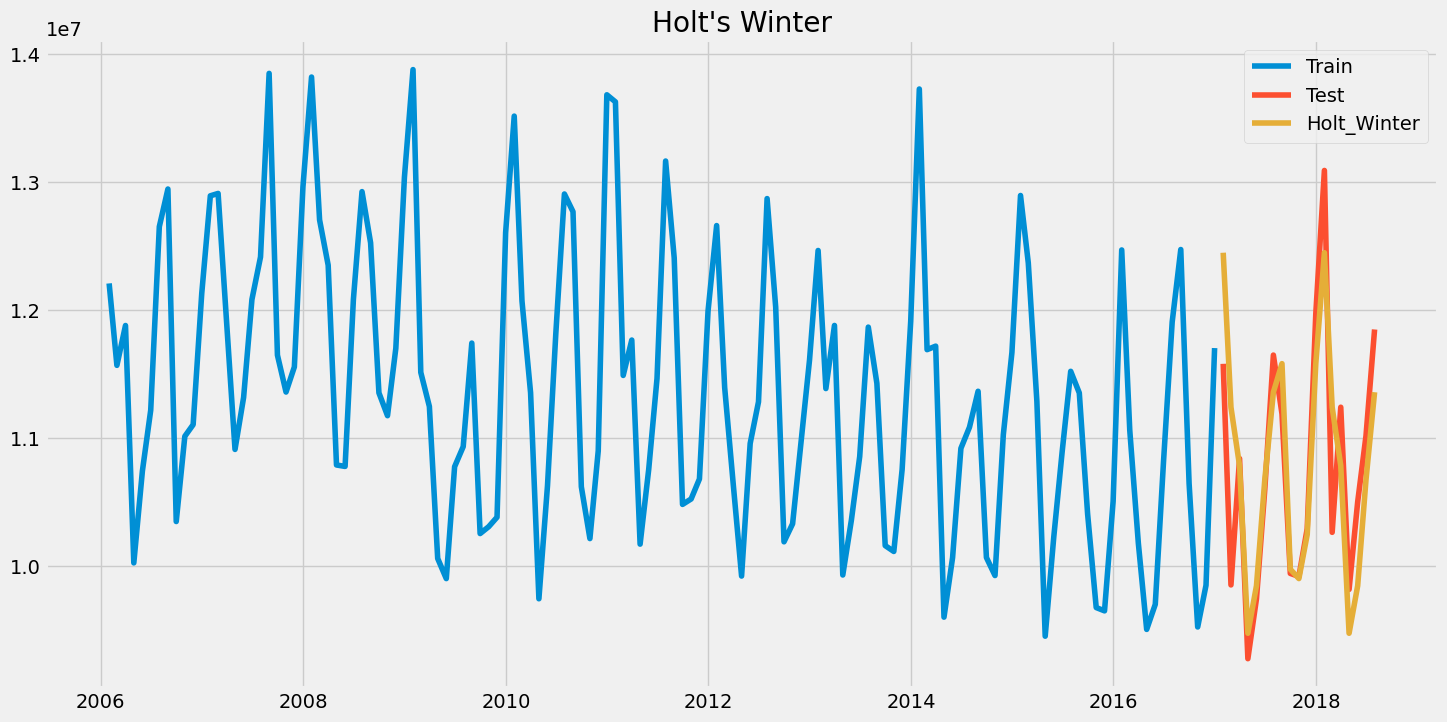

In [16]:
def holt_winters(train,test,seasonal_periods, trend,seasonal):
    fit = ExponentialSmoothing(train,seasonal_periods=seasonal_periods,trend=trend,seasonal=seasonal).fit()
    preds= fit.forecast(len(test)).values
    rms_ht = round(np.sqrt(mean_squared_error(test, preds)),2)
    return rms_ht
best_trend=''
best_season=''

rmse=1_000_000_000
for trend in ['add','mul',None]:
    for season in ['add','mul',None]:
        solution=holt_winters(train.energy.to_period('M'), test.energy,12, trend,season)
    #print(sl,solution)
        if solution<rmse:
            rmse=solution
            best_trend=trend
            best_season=season
fit = ExponentialSmoothing(train.energy.to_period('M') ,seasonal_periods=12 ,trend=best_trend, seasonal=best_season).fit()
preds['holt_winter'] = fit.forecast(len(test)).values
plt.figure(figsize=(16,8))
plt.plot( train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds.holt_winter, label='Holt_Winter')
plt.legend(loc='best')
plt.title("Holt's Winter");
plt.show()

In [17]:
rms_holtwinter = round(np.sqrt(mean_squared_error(test.energy, preds.holt_winter)),2)
results.loc['holt_winter']=rms_holtwinter/1_000_000
results=results.sort_values('rmse_per_million')
results

,rmse_per_million
holt_winter,0.543067
holt_linear,0.929768
SES,0.942778
moving_average,0.944048
simple_average,1.122177
naive,1.325609


In [18]:
results.to_csv('scores.csv')